In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL as pil
import cv2
import matplotlib.patches as patches

'''
For the 10x images on the Leica microscope we are getting a 449x599 um field of view.

this is returning a 768x1024 image, so we are getting about 0.587um per pixel.

'''
y_px_to_um = 449/768

202 28 114.64504623413086
norm_region: (200, 400, 0, 384)
228 27 115.5109494527181
norm_region: (200, 400, 0, 384)
200 27 113.55461247762044
norm_region: (200, 400, 0, 384)
226 29 111.47770309448242
norm_region: (200, 400, 0, 384)
191 34 136.968142191569
norm_region: (200, 400, 0, 384)
221 34 136.6851018269857
norm_region: (200, 400, 0, 384)
200 28 140.1911137898763
norm_region: (200, 400, 0, 384)
224 31 136.8816032409668
norm_region: (200, 400, 0, 384)
199 31 157.29067993164062
norm_region: (200, 400, 0, 384)
221 34 153.88299051920572
norm_region: (200, 400, 0, 384)
194 35 157.6003532409668
norm_region: (200, 400, 0, 384)
223 32 160.07886123657227
norm_region: (200, 400, 0, 384)
202 31 158.83281071980795
norm_region: (200, 400, 0, 384)
227 28 161.35533396402994
norm_region: (200, 400, 0, 384)
197 31 157.98408126831055
norm_region: (200, 400, 0, 384)
226 29 159.51195907592773
norm_region: (200, 400, 0, 384)
205 26 122.67338307698567
norm_region: (200, 400, 0, 384)
226 29 119.7039311726

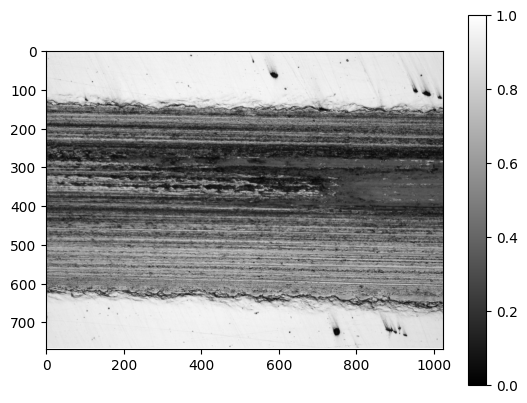

<Figure size 640x480 with 0 Axes>

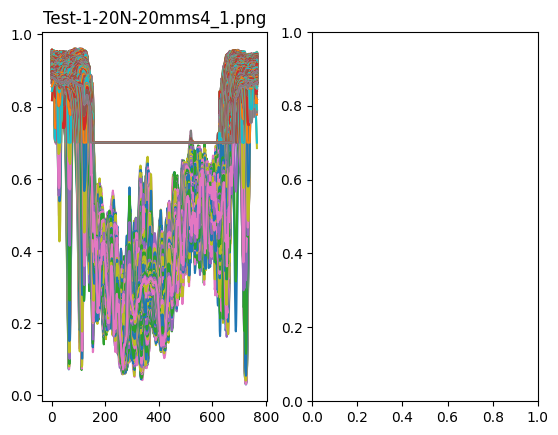

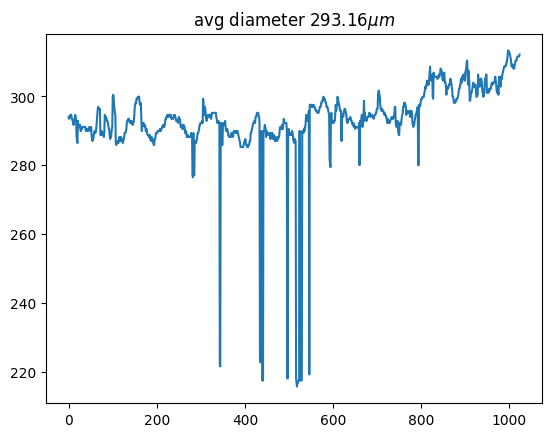

(768.0, 0.0)

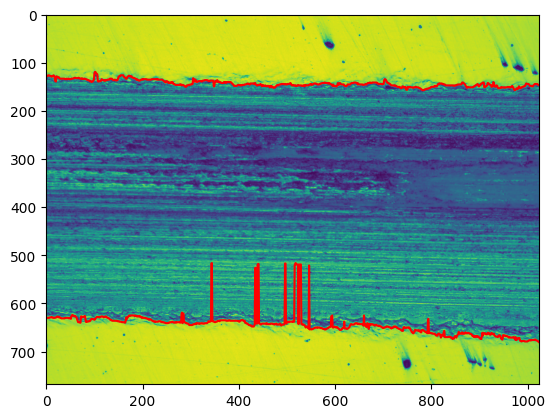

In [39]:

def normalize_array(arr, range=None):
	if range is not None:
		start_row, end_row, start_col, end_col = range
		print(f"range: {range}----------------------------------------------------------------------------")

	else:
		start_row, end_row, start_col, end_col = 0, arr.shape[0], 0, arr.shape[1]

	arr_min=np.min(arr[start_row:end_row, start_col:end_col])
	arr_max=np.max(arr[start_row:end_row, start_col:end_col])

	return np.clip((arr - arr_min) / (arr_max - arr_min), None, 1)

def load_images_from_directory(directory):
	images = []
	# print(os.listdir(directory))
	for filename in os.listdir(directory):
		if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
			img_path = os.path.join(directory, filename)
			# print(img_path)
			img = pil.Image.open(img_path).convert('L')
			img_array = np.array(img)

			img_array = img_array- np.min(img_array)
			# plt.imshow(img_array, cmap='gray')
			# plt.colorbar()
			# plt.show()
			# plt.clf()
			print(np.max(img_array), np.min(img), np.mean(img_array))
			norm_region=(200,400,0,int(img_array.shape[0]/2))
			print(f"norm_region: {norm_region}")
			img_array = normalize_array(img_array)

			# print(np.max(img_array), np.min(img), np.mean(img_array))
			# print(img_array)
			# plt.imshow(img_array, cmap='gray')
			# plt.colorbar()
			# Define the square overlay
			square_size_x = norm_region[1] - norm_region[0]
			square_size_y = norm_region[3] - norm_region[2]
			square_x = norm_region[0]
			square_y = norm_region[2]
			rect = patches.Rectangle((square_x, square_y), square_size_x, square_size_y, linewidth=1, edgecolor='r', facecolor='none')

			
			# plt.gca().add_patch(rect)
			# plt.show()
			# plt.clf()
			# print("======================")


			images.append(img_array)
	return images


def remove_noise(image):
	# Apply Gaussian Blur to remove noise
	return cv2.GaussianBlur(image, (11, 11), 0)


def moving_average(arr, window_size):
	if window_size < 1:
		raise ValueError("Window size must be at least 1")
	
	# Initialize the result array with the same size as the input array
	result = np.zeros_like(arr, dtype=float)
	
	# Calculate the moving average for each position
	for i in range(len(arr)):
		start = max(0, i - window_size // 2)
		end = min(len(arr), i + window_size // 2 + 1)
		result[i] = np.mean(arr[start:end])
	
	return result


def highpass_filter_array(arr, val):
	arr[arr < val] = val
	
	return arr

def longest_continuous_range(arr, val):
	mask = arr <= val
	diff = np.diff(mask.astype(int))
	ranges = np.where(diff != 0)[0] + 1
	
	if mask[0]:
		ranges = np.insert(ranges, 0, 0)
	if mask[-1]:
		ranges = np.append(ranges, len(mask))
	
	max_len = 0
	longest_range = []
	start_index = end_index = -1
	
	for start, end in zip(ranges[::2], ranges[1::2]):
		if end - start > max_len:
			max_len = end - start
			longest_range = arr[start:end]
			start_index = start
			end_index = end
	
	return len(longest_range), (start_index, end_index)


# Example usage
directory_path = 'images'
images = load_images_from_directory(directory_path)
images_list = os.listdir(directory_path)
image_index = 0
image = images[image_index]
# image2 = images[image_index + 1]
samples = int(image.shape[1])
wear_scar_diameter = np.zeros(samples)
wear_scar_positions = np.zeros((samples, 2))
print(image.shape, type(image))
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show()
plt.clf()
separation=1
filter_value=0.7

fig,ax=plt.subplots(1,2)
for ii in range(samples):
	column = moving_average(image[:, ii * separation], 10)
	
	ax[0].plot(column)
	ax[0].set_title(images_list[image_index])
	
	ax[0].plot(highpass_filter_array(column, filter_value))
	
	
	# ax[1].plot(np.gradient(column))
	wear_scar_diameter[ii], wear_scar_positions[ii] = longest_continuous_range(column, filter_value)
	wear_scar_diameter[ii] = wear_scar_diameter[ii] * y_px_to_um
	# print(wear_scar_diameter[ii])    

plt.show()
plt.plot(wear_scar_diameter)
plt.title(f'avg diameter {np.average(wear_scar_diameter):.2f}$\mu m$')
plt.show()
plt.imshow(image)
plt.plot(wear_scar_positions, c='r')
plt.ylim(768, 0)
	

Inclination of the first fit: 0.031224718801199418 radians, 1.789044603791518 degrees
Inclination of the second fit: 0.07608218468871149 radians, 4.359188078798021 degrees
Average rotation angle: 1.5171428750499412


Text(0, 0.5, 'Position y $(\\mu m)$')

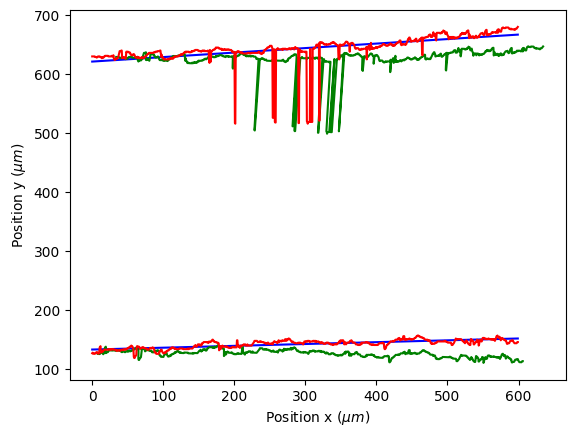

In [37]:
x_coords = np.linspace(0,599, samples)

coeffs1=np.polyfit(x_coords,wear_scar_positions[:,0],1)
linear_fit1=np.poly1d(coeffs1)
x_fit1 = np.linspace(x_coords.min(), x_coords.max(), samples)
y_fit = linear_fit1(x_fit1)

m1 = coeffs1[0]
theta1_radians = np.arctan(m1)
theta1_degrees = np.degrees(theta1_radians)
print(f"Inclination of the first fit: {theta1_radians} radians, {theta1_degrees} degrees")


coeffs2=np.polyfit(x_coords,wear_scar_positions[:,1],1)
linear_fit2=np.poly1d(coeffs2)
x_fit2=np.linspace(x_coords.min(), x_coords.max(), samples)

m2 = coeffs2[0]
theta2_radians = np.arctan(m2)
theta2_degrees = np.degrees(theta2_radians)
print(f"Inclination of the second fit: {theta2_radians} radians, {theta2_degrees} degrees")


rotation_angle=-(np.average([theta1_radians,theta2_radians])-np.pi/2)
print(f"Average rotation angle: {rotation_angle}")
rotation_matrix = np.array([
    [np.cos(rotation_angle), -np.sin(rotation_angle)],
    [np.sin(rotation_angle), np.cos(rotation_angle)]
])

rotated_positions1 = np.dot(np.array((wear_scar_positions[:,0],-x_coords)).T, rotation_matrix.T)
rotated_positions2 = np.dot(np.array((wear_scar_positions[:,1],-x_coords)).T, rotation_matrix.T)
y_fit2=linear_fit2(x_fit2)
plt.plot(x_fit1, y_fit, c='b')
plt.plot(x_fit2, y_fit2, c='b')

plt.plot(rotated_positions1[:,0],rotated_positions1[:,1], c='g')
plt.plot(rotated_positions2[:,0],rotated_positions2[:,1], c='g')

plt.plot(x_coords,wear_scar_positions, c='r')

plt.xlabel('Position x $(\mu m)$')
plt.ylabel('Position y $(\mu m)$')
# plt.legend()

In [ ]:
import plotly.graph_objects as go

X, Y = np.meshgrid(range(image.shape[1]), range(image.shape[0]))
Z = image

# Create a 3D plot using Plotly
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Gray')])

fig.update_layout(title='3D Surface Plot', autosize=True,
                  scene=dict(zaxis=dict(range=[0, 1])),
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
import numpy as np
from scipy.spatial import distance

# Example datasets
dataset1 = np.array((x_fit1, y_fit)).T
dataset2 = np.array((x_fit2, y_fit2)).T

# Fit lines to both datasets
coeffs1 = np.polyfit(dataset1[:, 0], dataset1[:, 1], 1)
coeffs2 = np.polyfit(dataset2[:, 0], dataset2[:, 1], 1)

# Line equation for dataset2: y = m2*x + b2
m2, b2 = coeffs2

def perpendicular_distance(point, m, b):
    """Calculate the perpendicular distance from a point to a line y = mx + b."""
    x, y = point[0], point[1]
    return abs(m*x - y + b) / np.sqrt(m**2 + 1)

# Calculate distances
distances = np.array([perpendicular_distance(point, m2, b2) for point in dataset1])*y_px_to_um
plt.plot(distances)
print(f"Average distance: {np.average(distances):.2f}$\mu m$")